In [17]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

def a4_rand(requested_size, seed):
    ''' PS: Returns array of pseudo-random values from 0 to 1.
    Array sizes are requested_size, seed - some pseudo-random initializer
    '''
    requested_size = list(requested_size)
    start_i = round(seed) % round(randomness_source.shape[1] / 10) + 1
    if start_i + np.prod(requested_size) >= randomness_source.shape[1] + 1:
        exit('a4_rand failed to generate an array of that size (too big)')
    ret = np.reshape(randomness_source[:,start_i-1:start_i + \
                                            np.prod(requested_size)-1],
            tuple(requested_size), order="F")
    return ret

def extract_mini_batch(data_set, start_i, n_cases):
    ''' PS: Extract n_cases samples from dataset, starting from start_i.
    '''
    mini_batch = {}
    mini_batch['inputs'] = data_set['inputs'][:,
                                    start_i-1 : start_i + n_cases - 1]
    mini_batch['targets'] = data_set['targets'][:,
                                    start_i-1 : start_i + n_cases - 1]
    return mini_batch

def sample_bernoulli(probabilities):
    if report_calls_to_sample_bernoulli:
        print('sample_bernoulli() was called with a matrix of size',
              probabilities.shape[0], "by", probabilities.shape[1], ".")
    seed = np.sum(probabilities)

    # the "1*" is to avoid the "logical" data type, which just confuses things.
    binary = 1*(probabilities > a4_rand(probabilities.shape, float(seed)))

    return binary

def optimize(model_shape, gradient_function, training_data,
             learning_rate, n_iterations):
    # This trains a model that's defined by a single matrix of weights.
    # <model_shape> is the shape of the array of weights.
    # <gradient_function> is a function that takes parameters <model> and
    # <data> and returns the gradient (or approximate gradient in the case
    # of CD-1) of the function that we're maximizing. Note the contrast with
    # the loss function that we saw in PA3, which we were minimizing. The
    # returned gradient is an array of the same shape as the provided <model>
    # parameter.
    # This uses mini-batches of size 100, momentum of 0.9, no weight
    # decay, and no early stopping.
    # This returns the matrix of weights of the trained model.

    model = (a4_rand(model_shape, np.prod(model_shape)) * 2 - 1) * 0.1
    momentum_speed = np.zeros(model_shape)
    mini_batch_size = 100
    start_of_next_mini_batch = 1
    for iteration_number in range(n_iterations):
        mini_batch = extract_mini_batch(training_data,
                        start_of_next_mini_batch, mini_batch_size)
        start_of_next_mini_batch = (start_of_next_mini_batch + mini_batch_size) % \
                                   training_data['inputs'].shape[1]
        gradient = gradient_function(model, mini_batch)
        momentum_speed = 0.9 * momentum_speed + gradient
        model = model + momentum_speed * learning_rate

    return model

def show_rbm(rbm_w):
    n_hid = rbm_w.shape[0]
    n_rows = int(np.ceil(np.sqrt(n_hid)))

    blank_lines = 4
    distance = 16 + blank_lines
    to_show = np.zeros([n_rows * distance + blank_lines,
                        n_rows * distance + blank_lines])
    for i in range(n_hid):
        row_i = int(np.floor(i / n_rows))
        col_i = i % n_rows
        pixels = np.transpose(np.reshape(rbm_w[i, :], [16, 16]))
        row_base = row_i*distance + blank_lines
        col_base = col_i*distance + blank_lines
        to_show[row_base:row_base+16, col_base:col_base+16] = pixels
    extreme = np.max(np.abs(to_show))

    plt.imshow(to_show, cmap='gray')
    plt.title('hidden units of the RBM')
    plt.show()

def logistic(input):
    return 1 / (1 + np.exp(-input))

def classification_phi_gradient(input_to_class, data):
    # This is about a very simple model: there's an input layer, and
    # a softmax output layer. There are no hidden layers, and no biases.
    # This returns the gradient of phi (a.k.a. negative the loss) for
    # the <input_to_class> matrix.
    # <input_to_class> is a matrix of size <number of classes> by
    # <number of input units>.
    # <data> has fields .inputs (matrix of size <number of input units> by
    # <number of data cases>) and .targets (matrix of size <number of classes>
    # by <number of data cases>).
    # first: forward pass
    class_input = np.dot(input_to_class, data['inputs'])
    # input to the components of the softmax.
    # size: <number of classes> by <number of data cases>
    class_normalizer = log_sum_exp_over_rows(class_input)
    # log(sum(exp)) is what we subtract to get normalized log class
    # probabilities. size: <1> by <number of data cases>
    log_class_prob = class_input - \
            np.tile(class_normalizer, (class_input.shape[0], 1))
    # log of probability of each class. size: <number of classes> by
    # <number of data cases>
    class_prob = np.exp(log_class_prob)
    # probability of each class. Each column (i.e. each case) sums to 1.
    # size: <number of classes> by <number of data cases>

    # now: gradient computation
    d_loss_by_d_class_input = -(data['targets'] - class_prob) / data['inputs'].shape[1]
    # size: <number of classes> by <number of data cases>
    d_loss_by_d_input_to_class = np.dot(d_loss_by_d_class_input,
                                        np.transpose(data['inputs']))
    # size: <number of classes> by <number of input units>
    d_phi_by_d_input_to_class = -d_loss_by_d_input_to_class
    return d_phi_by_d_input_to_class

def argmax_over_rows(matrix):
    indices = np.argmax(matrix, axis=0)
    return indices

def log_sum_exp_over_rows(matrix):
    # This computes log(sum(exp(a), 1)) in a numerically stable way
    maxs_small = np.amax(matrix, axis=0)
    maxs_big = np.tile(maxs_small, (matrix.shape[0], 1))
    ret = np.log(np.sum(np.exp(matrix - maxs_big), axis=0)) + maxs_small
    return ret

def describe_matrix(matrix):
    print('Describing a matrix of size', matrix.shape[0], 'by',
          matrix.shape[1], '. The mean of the elements is', np.mean(matrix),
          '. The sum of the elements is', np.sum(matrix))

def a4_main(n_hid, lr_rbm, lr_classification, n_iterations):
    # first, train the rbm
    global report_calls_to_sample_bernoulli
    report_calls_to_sample_bernoulli = False

    rbm_w = optimize([n_hid, 256],
                     lambda rbm_w,data: cd1(rbm_w,data['inputs']), # discard labels
                     training_data, lr_rbm, n_iterations)
    # rbm_w is now a weight matrix of <n_hid> by
    # <number of visible units, i.e. 256>
    show_rbm(rbm_w)

    input_to_hid = rbm_w
    # calculate the hidden layer representation of the labeled data
    hidden_representation = logistic(np.dot(input_to_hid, training_data['inputs']))
    # train hid_to_class
    data_2 = {}
    data_2['inputs'] = hidden_representation
    data_2['targets'] = training_data['targets']
    hid_to_class = optimize([10, n_hid],
        lambda model, data: classification_phi_gradient(model, data),
        data_2, lr_classification, n_iterations)
    # report results
    data_details = [['training', training_data],
                    ['validation', validation_data],
                    ['test', test_data]]
    for data_item in data_details:
        data_name = data_item[0]
        data = data_item[1]
        # size: <number of hidden units> by <number of data cases>
        hid_input = np.dot(input_to_hid, data['inputs'])

        # size: <number of hidden units> by <number of data cases>
        hid_output = logistic(hid_input)

        # size: <number of classes> by <number of data cases>
        class_input = np.dot(hid_to_class, hid_output)

        # log(sum(exp of class_input)) is what we subtract to get properly
        # normalized log class probabilities. size: <1> by <number of data cases>
        class_normalizer = log_sum_exp_over_rows(class_input)

        # log of probability of each class. size: <number of classes, i.e. 10>
        # by <number of data cases>
        log_class_prob = class_input - np.tile(class_normalizer,
                                    (class_input.shape[0], 1))

        error_rate = np.mean((argmax_over_rows(class_input) !=
                              argmax_over_rows(data['targets']))) # scalar

        # scalar. select the right log class probability using that sum;
        # then take the mean over all data cases.
        loss = -np.mean(np.sum(log_class_prob * data['targets'], axis=0))

        print('For the', data_name, 'data, the classification cross-entropy '
            'loss is', loss, ', and the classification error rate (i.e. the '
            'misclassification rate) is', error_rate)

    report_calls_to_sample_bernoulli = True


In [4]:

#### ---- Main program

# Part 1 - Initialization
# PS: This initialization is analogous to a4_init.m

# Load base for pseudorandom generator
randomness_source = sio.loadmat('a4_randomness_source.mat')['randomness_source']

# Load data: arrays of 16x16 images of greyscale hand-written digits
from_data_file = sio.loadmat('data_set.mat')['data']
training_data = {}
training_data['inputs'] = from_data_file[0][0]['training'][0][0]['inputs']
training_data['targets'] = from_data_file[0][0]['training'][0][0]['targets']
validation_data = {}
validation_data['inputs'] = from_data_file[0][0]['validation'][0][0]['inputs']
validation_data['targets'] = from_data_file[0][0]['validation'][0][0]['targets']
test_data = {}
test_data['inputs'] = from_data_file[0][0]['test'][0][0]['inputs']
test_data['targets'] = from_data_file[0][0]['test'][0][0]['targets']

report_calls_to_sample_bernoulli = False

test_rbm_w = a4_rand((100, 256), 0) * 2 - 1
small_test_rbm_w = a4_rand((10, 256), 0) * 2 - 1

temp = extract_mini_batch(training_data, 1, 1)
data_1_case = sample_bernoulli(temp['inputs'])
temp = extract_mini_batch(training_data, 100, 10)
data_10_cases = sample_bernoulli(temp['inputs'])
temp = extract_mini_batch(training_data, 200, 37)
data_37_cases = sample_bernoulli(temp['inputs'])

test_hidden_state_1_case = sample_bernoulli(a4_rand([100, 1], 0))
test_hidden_state_10_cases = sample_bernoulli(a4_rand([100, 10], 1))
test_hidden_state_37_cases = sample_bernoulli(a4_rand([100, 37], 2))

report_calls_to_sample_bernoulli = True

del temp

# Part 2 - Main part
# a4_main(300, 0, 0, 0)

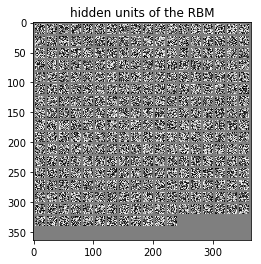

For the training data, the classification cross-entropy loss is 2.35711117506 , and the classification error rate (i.e. the misclassification rate) is 0.878
For the validation data, the classification cross-entropy loss is 2.3607361485 , and the classification error rate (i.e. the misclassification rate) is 0.877
For the test data, the classification cross-entropy loss is 2.35858281922 , and the classification error rate (i.e. the misclassification rate) is 0.879888888889


In [4]:
a4_main(300, 0, 0, 0)
# Q2 2.3607361

In [5]:

def visible_state_to_hidden_probabilities(rbm_w, visible_state):
    # <rbm_w> is a matrix of size <number of hidden units> by
    # <number of visible units>
    # <visible_state> is a binary matrix of size <number of visible units> by
    # <number of configurations that we're handling in parallel>.
    # The returned value is a matrix of size <number of hidden units> by
    # <number of configurations that we're handling in parallel>.
    # This takes in the (binary) states of the visible units, and returns the
    # activation probabilities of the hidden units conditional on those states.
    
    #Tested
    
    return 1/(1+np.exp(-rbm_w@visible_state))
    
#     exit("Not yet implemented")

In [6]:
a = visible_state_to_hidden_probabilities(test_rbm_w, data_37_cases)
print(np.mean(a))
print(np.sum(a))
#Q3 1724.9676

0.466207462338
1724.96761065


In [7]:
def hidden_state_to_visible_probabilities(rbm_w, hidden_state):
    # <rbm_w> is a matrix of size <number of hidden units> by
    # <number of visible units>
    # <hidden_state> is a binary matrix of size <number of hidden units> by
    # <number of configurations that we're handling in parallel>.
    # The returned value is a matrix of size <number of visible units> by
    # <number of configurations that we're handling in parallel>.
    # This takes in the (binary) states of the hidden units, and returns the
    # activation probabilities of the visible units, conditional on those states.
    
    return 1/(1+np.exp(-rbm_w.T@hidden_state))
    #exit("Not yet implemented")


In [104]:
a = hidden_state_to_visible_probabilities(test_rbm_w, test_hidden_state_37_cases)
print(np.mean(a))
print(np.sum(a))
#Q4 4391.1695

0.463594761745
4391.16958325


In [8]:
def configuration_goodness(rbm_w, visible_state, hidden_state):
    # <rbm_w> is a matrix of size <number of hidden units> by
    # <number of visible units>
    # <visible_state> is a binary matrix of size <number of visible units> by
    # <number of configurations that we're handling in parallel>.
    # <hidden_state> is a binary matrix of size <number of hidden units> by
    # <number of configurations that we're handling in parallel>.
    # This returns a scalar: the mean over cases of the goodness (negative energy)
    # of the described configurations.
    a = np.sum(hidden_state*(rbm_w@visible_state),axis = 0)
    return np.mean(a)
    #exit("Not yet implemented")

In [102]:
a = configuration_goodness(test_rbm_w, data_37_cases, test_hidden_state_37_cases)
print(np.mean(a))
print(np.sum(a))
# Q5 -18.39137

-18.3913760102
-18.3913760102


In [9]:

def configuration_goodness_gradient(visible_state, hidden_state):
    # <visible_state> is a binary matrix of size <number of visible units> by
    # <number of configurations that we're handling in parallel>.
    # <hidden_state> is a (possibly but not necessarily binary) matrix of size
    # <number of hidden units> by <number of configurations that
    # we're handling in parallel>.
    # You don't need the model parameters for this computation.
    # This returns the gradient of the mean configuration goodness
    # (negative energy, as computed by function <configuration_goodness>) with
    # respect to the model parameters. Thus, the returned value is of the same
    # shape as the model parameters, which by the way are not provided to this
    # function. Notice that we're talking about the mean over data cases
    # (as opposed to the sum over data cases).
    return (visible_state@hidden_state.T)/visible_state.shape[1]
#     exit("Not yet implemented")

In [101]:
a = configuration_goodness_gradient(data_37_cases, test_hidden_state_37_cases)
print(np.mean(a))
print(np.sum(a))
# Q6 3166.21621

0.123680320946
3166.21621622


In [10]:
def cd1(rbm_w, visible_data):
    # <rbm_w> is a matrix of size <number of hidden units> by
    # <number of visible units>
    # <visible_data> is a (possibly but not necessarily binary) matrix
    # of size <number of visible units> by <number of data cases>
    # The returned value is the gradient approximation produced by CD-1.
    # It's of the same shape as <rbm_w>.
    
    v0 = visible_data
    h0 = sample_bernoulli(visible_state_to_hidden_probabilities(rbm_w, v0))
    v1 = sample_bernoulli(hidden_state_to_visible_probabilities(rbm_w, h0))
    h1 = sample_bernoulli(visible_state_to_hidden_probabilities(rbm_w, v1))
    
    return configuration_goodness_gradient(v0,h0) - configuration_goodness_gradient(v1,h1)

In [121]:
a = cd1(test_rbm_w, data_37_cases)
print(np.sum(a))
print(np.mean(a))
# Q7 -4669.6756

sample_bernoulli() was called with a matrix of size 100 by 37 .
sample_bernoulli() was called with a matrix of size 256 by 37 .
sample_bernoulli() was called with a matrix of size 100 by 37 .
-4669.67567568
-0.182409206081


In [27]:
def cd1(rbm_w, visible_data):
    # <rbm_w> is a matrix of size <number of hidden units> by
    # <number of visible units>
    # <visible_data> is a (possibly but not necessarily binary) matrix
    # of size <number of visible units> by <number of data cases>
    # The returned value is the gradient approximation produced by CD-1.
    # It's of the same shape as <rbm_w>.
    
    v0 = sample_bernoulli(visible_data)
    h0 = sample_bernoulli(visible_state_to_hidden_probabilities(rbm_w, v0))
    v1 = sample_bernoulli(hidden_state_to_visible_probabilities(rbm_w, h0))
    h1 = visible_state_to_hidden_probabilities(rbm_w, v1)
    res = (configuration_goodness_gradient(v0,h0) - configuration_goodness_gradient(v1,h1)).T
    if res.shape!=rbm_w.shape:
        print (res.shape,rbm_w.shape)
    return res

In [128]:
a = cd1(test_rbm_w, data_37_cases)
print(np.sum(a))
print(np.mean(a))
# Q8 -4716.09497

sample_bernoulli() was called with a matrix of size 100 by 37 .
sample_bernoulli() was called with a matrix of size 256 by 37 .
-4716.09497222
-0.184222459852


Current alpha : 0.0935


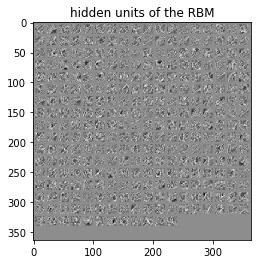

For the training data, the classification cross-entropy loss is 0.0277119072552 , and the classification error rate (i.e. the misclassification rate) is 0.0
For the validation data, the classification cross-entropy loss is 0.198606740161 , and the classification error rate (i.e. the misclassification rate) is 0.057
For the test data, the classification cross-entropy loss is 0.22560570503 , and the classification error rate (i.e. the misclassification rate) is 0.0658888888889
Current alpha : 0.0937


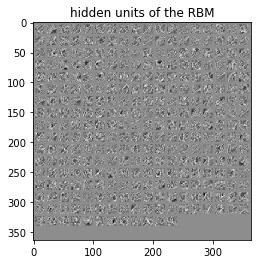

For the training data, the classification cross-entropy loss is 0.0276531903509 , and the classification error rate (i.e. the misclassification rate) is 0.0
For the validation data, the classification cross-entropy loss is 0.198606609043 , and the classification error rate (i.e. the misclassification rate) is 0.057
For the test data, the classification cross-entropy loss is 0.225615298469 , and the classification error rate (i.e. the misclassification rate) is 0.0658888888889
Current alpha : 0.0939


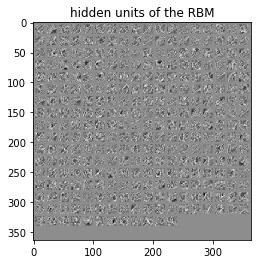

For the training data, the classification cross-entropy loss is 0.0275947162562 , and the classification error rate (i.e. the misclassification rate) is 0.0
For the validation data, the classification cross-entropy loss is 0.198606565538 , and the classification error rate (i.e. the misclassification rate) is 0.058
For the test data, the classification cross-entropy loss is 0.225624960601 , and the classification error rate (i.e. the misclassification rate) is 0.0658888888889
Current alpha : 0.0941


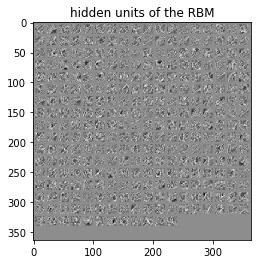

For the training data, the classification cross-entropy loss is 0.0275364834851 , and the classification error rate (i.e. the misclassification rate) is 0.0
For the validation data, the classification cross-entropy loss is 0.198606609051 , and the classification error rate (i.e. the misclassification rate) is 0.058
For the test data, the classification cross-entropy loss is 0.22563469089 , and the classification error rate (i.e. the misclassification rate) is 0.0658888888889


In [39]:
for alpha in (0.0935,0.0937,0.0939,0.0941):
    print ("Current alpha :", alpha)
    a4_main(300, .02, alpha, 1000)
# Q9 0.0939
# Q10 0.065888